In [1]:
from src.utils import draw, draw_trajectories
from src.simulation import simulation
from src.PIDController import PID_Controller

In [2]:
import numpy as np

from tqdm import trange

# System definition

## Starting state

- First tuple: $(x, y)$
- Second tuple: $(x_{speed}, y_{speed})$
- Angle in degree

In [3]:
start   = [(100, 100), (0, 0), 0]

## Target state

- First tuple: $(x, y)$
- Second tuple: $(x_{speed}, y_{speed})$
- Angle in degree

In [54]:
# targets = np.array([[500, 400, 0, 0],
#                     [400, 700, 0, 0],
#                     [800, 800, 0, 0],
#                     [900, 900, 0, 0]
                   # ])
targets = np.array([
                    [150, 125, 0, 0],
                    [200, 175, 0, 0],
                    [250, 225, 0, 0],
                    [300, 225, 0, 0],
                    [350, 275, 0, 0],
                    [450, 375, 0, 0],
                    [450, 400, 0, 0],
                    [450, 500, 0, 0],
                    [450, 550, 0, 0],
                    [450, 600, 0, 0],
                    [600, 700, 0, 0],
                    [650, 700, 0, 0],
                    [700, 750, 0, 0],
                    [750, 840, 0, 0],
                    [800, 870, 0, 0],
                    [850, 900, 0, 0],
                    [900, 900, 0, 0],
                   ])

## Obstacles state

- First tuple: $(x, y)$
- Angle in degree

In [5]:
obstacles = [[(300, 350), 0], 
             [(600, 400), 0],
             [(600, 600), 0],
             [(800, 700), 0]
            ]

## Noise

Possible noise that can be used
$$(x, y, x_{speed}, y_{speed})$$

In [55]:
# noise         = [3, 3, 1e-16, 1e-16]
# noise         = [1e-16, 1e-16, 0.25, 0.25]
noise         = [0.5]*4
# noise         = [1e-16, 1e-16, 1e-16, 1e-16]

# PID Optimization

Requires some time, to speed-up the process some nice values were found
- One when using Kalman filter
- One when using Luemberger Observer

In [7]:
initial_guess = [0.5, 0.5, 0.5]   

kalman = True
# kalman = False

use_PID = True
# use_PID = False

## Optimization

In [57]:
if use_PID:
    PID = PID_Controller(start, obstacles, targets, reference=0, simulation_time=1000, kalman=kalman, noise=noise, LQR=False)
    K   = PID.optimize_pid(initial_guess)
    Kp, Ki, Kd = K

    print(K)

[3.09185366 2.5        4.15831335]


In [29]:
PID = PID_Controller(start, obstacles, targets, reference=0, simulation_time=1000, kalman=kalman, noise=noise)
Kp, Ki, Kd = [2.12980982, 0.31436232, 0.53444185]

In [9]:
# tollerated-noise
# NO-PID-KALMAN: 
#                [0, 0, 0, 0] -> [0, 0, 4, 4] 
#                [0, 0, 0, 0] -> [7, 7, 0, 0] 
# NO-PID-LUENBE: 
#                [0, 0, 0, 0] -> [0, 0, 4, 4] 
#                [0, 0, 0, 0] -> [7, 7, 0, 0] 

# To fix (?)
# PID-LUENBE: 
#                [0, 0, 0, 0] -> [0, 0, 4, 4] 
#                [0, 0, 0, 0] -> [7, 7, 0, 0] 
# PID-KALMAN: 
#                [0, 0, 0, 0] -> [0, 0, 4, 4] 
#                [0, 0, 0, 0] -> [7, 7, 0, 0] 

# Simulations

In [22]:
Kp, Ki, Kd = [1.12980982, 0.15436232, 0.25444185]

In [58]:
simulations = 100
simulation_time = 600
dt = 0.5

states        = np.zeros((simulations, int(simulation_time/dt) + 1, 4))
u_list        = np.zeros((simulations, int(simulation_time/dt), 2))
reference_list= np.zeros((simulations, int(simulation_time/dt)))
theta_list    = np.zeros((simulations, int(simulation_time/dt)))

has_completed = np.zeros((simulations))
has_collided  = np.zeros((simulations))

bar = trange(simulations)

for i in bar:
    states[i], u_list[i], target_list, reference_list[i], theta_list[i], has_completed[i], has_collided[i] = simulation(start, obstacles, targets, PID, Kp=Kp, Ki=Ki, Kd=Kd, simulation_time=simulation_time, kalman=kalman, noise=noise, reference=0, dt=dt, LQR=False)
    bar.set_postfix({"has_completed": np.mean(has_completed[:i]), "has_collided": np.mean(has_collided[:i])})

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:06<00:00,  1.51it/s, has_completed=1, has_collided=0.0101]


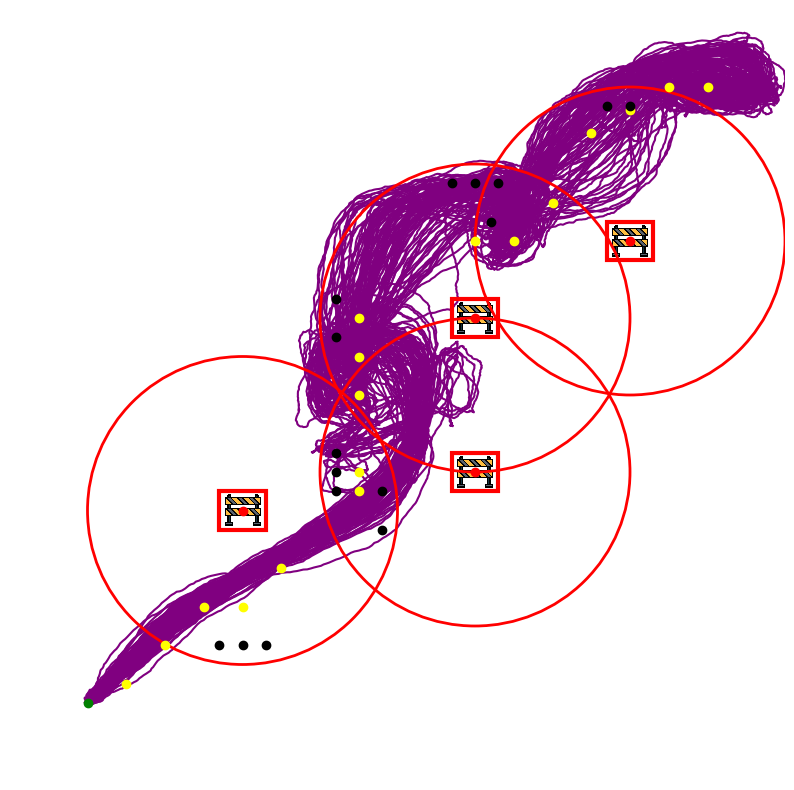

In [59]:
ax = draw_trajectories(obstacles, start, targets, states, target_list)

In [60]:
has_completed.mean()

np.float64(1.0)

In [61]:
has_collided.mean()

np.float64(0.01)

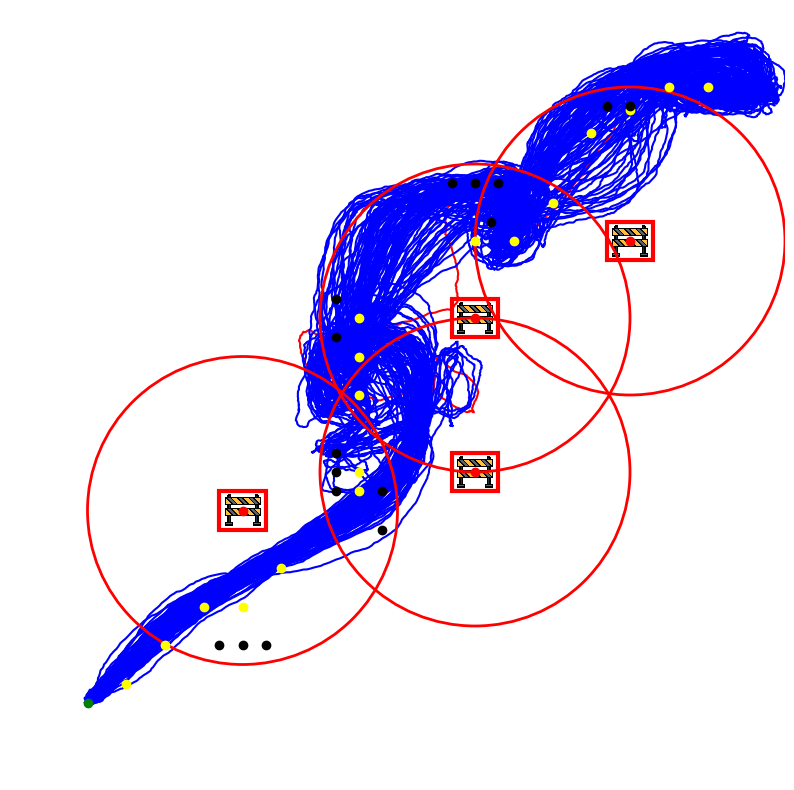

In [62]:
from src.Obstacle import Obstacle
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Circle

# Initialize the Obstacles
obstacles_draw = np.array([Obstacle(coords, angle) for coords, angle in obstacles])

# Initialize the plot
image_size = 1000
fig = plt.figure(figsize=(image_size / 100, image_size / 100), dpi=100)
ax = plt.gca()
ax.axis('off')

ax.set_xlim(0, image_size)
ax.set_ylim(0, image_size)

# Plot the trajectories
colors = ["blue" if completed and not collided else "red" for completed, collided in zip(has_completed, has_collided)]
for state, color in zip(states, colors):
    ax.plot(state[:, 0], state[:, 1], color=color)

# Plot the starting position
ax.scatter(start[0][0], start[0][1], color="green", zorder=10)

# Plot the obstacles and relative detection boundings
for obstacle in obstacles_draw:
    obstacle.draw(ax)
    ax.add_patch(Circle(obstacle.get_coords(), 200, lw=2, facecolor="None", edgecolor="red", zorder=10))

# Plot the target position
ax.scatter(targets[:, 0], targets[:, 1], color="yellow", zorder=10)

if len(target_list) > 0:
    # Plot the temporaneous target positions
    ax.scatter(target_list[:, 0], target_list[:, 1], color="black", zorder=10)

# Show the plot
plt.show()

In [63]:
ref_x, ref_y = reference_list * np.cos(theta_list), reference_list * np.sin(theta_list), 

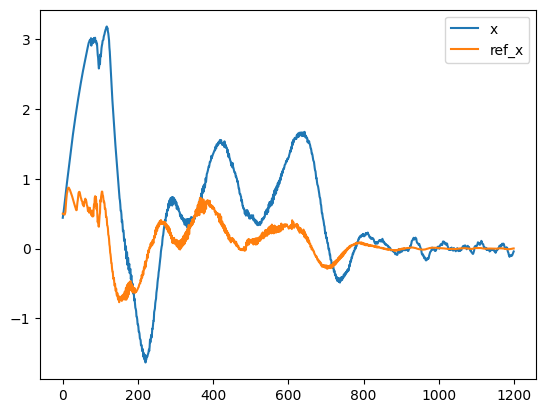

In [64]:
import matplotlib.pyplot as plt
plt.plot(np.arange(u_list.shape[1]), u_list.mean(0)[:, 0], label="x")
plt.plot(np.arange(u_list.shape[1]), ref_x.mean(0), label="ref_x")
plt.legend()

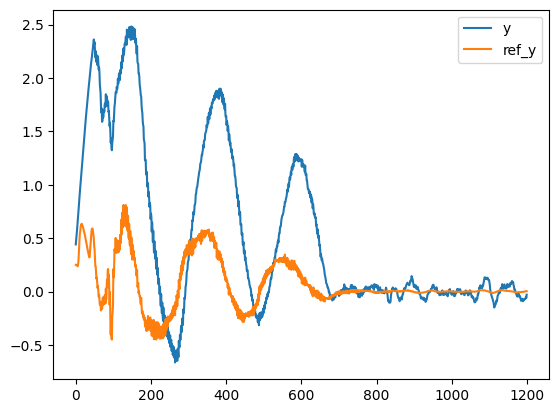

In [65]:
plt.plot(np.arange(u_list.shape[1]), u_list.mean(0)[:, 1], label="y")
plt.plot(np.arange(u_list.shape[1]), ref_y.mean(0), label="ref_y")
plt.legend()


In [66]:
u_modules = u_list**2
u_modules = u_modules.sum(-1)
u_modules = np.sqrt(u_modules)

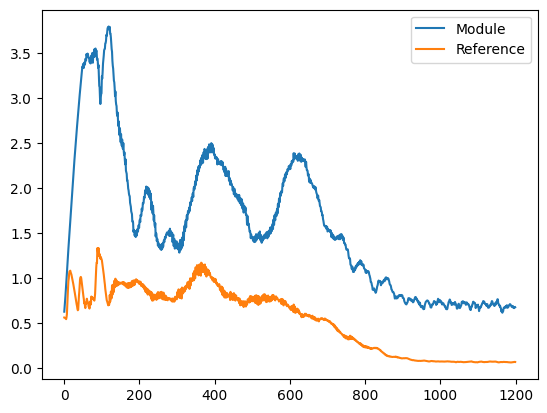

In [67]:
plt.plot(np.arange(u_modules.shape[1]), u_modules.mean(0), label="Module")
plt.plot(np.arange(reference_list.shape[1]), reference_list.mean(0), label="Reference")
plt.legend()